In [ ]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import spacy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/data/newcorp.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   article_id          266 non-null    int64 
 1   title               266 non-null    object
 2   article_text        266 non-null    object
 3   summary_1_text      266 non-null    object
 4   summary_2_text      266 non-null    object
 5   summary_3_text      266 non-null    object
 6   summary_4_text      266 non-null    object
 7   summary_5_text      266 non-null    object
 8   thesis_1_text       266 non-null    object
 9   thesis_2_text       266 non-null    object
 10  thesis_3_text       266 non-null    object
 11  thesis_4_text       266 non-null    object
 12  thesis_5_text       266 non-null    object
 13  lead                266 non-null    object
 14  body                266 non-null    object
 15  conclusion          266 non-null    object
 16  article_segments    266 no

In [ ]:
text_list=[]
label_list=[]

In [ ]:
def datasetmaker(x):
    x=json.loads(x)
    for i in range(0,len(x["paragraphs"])):
        for j in range(0,len(x["paragraphs"][i])):
            text_list.append(x["paragraphs"][i][j]["text"])
            label_list.append(x["paragraphs"][i][j]["label"])

In [ ]:
df["article_segments"].apply(lambda x:datasetmaker(x))

0      None
1      None
2      None
3      None
4      None
       ... 
261    None
262    None
263    None
264    None
265    None
Name: article_segments, Length: 266, dtype: object

In [ ]:
len(text_list)

28772

In [ ]:
len(label_list)

28772

In [ ]:
df_main={"text":text_list,"labels":label_list}

In [ ]:
df_main=pd.DataFrame(df_main)

In [ ]:
df_main.head()

,text,labels
0,"2015: Beyond Obama, new Congress, we need a re...",title
1,"In the film, ""Girl Interrupted,"" Winona Ryder ...",anecdote
2,.,no-unit
3,The year is 1967,anecdote
4,and,no-unit


In [ ]:
len(text_list)

28772

In [ ]:
df_main["labels"].value_counts()

no-unit          15193
assumption        9049
anecdote          2430
testimony         1064
statistics         381
title              266
common-ground      232
other              157
Name: labels, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

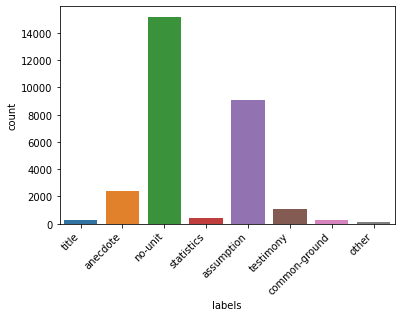

In [ ]:
sns.countplot(data=df_main,x="labels")
plt.xticks(rotation=45, ha='right')

In [ ]:
df_main[df_main["labels"]=="no-unit"]["text"]

2                    .
4                  and
6                    .
8                    .
10       As 2014 ends,
             ...      
28763                -
28765                .
28767                .
28769                .
28771                .
Name: text, Length: 15193, dtype: object

In [ ]:
len_no_unit=df_main[df_main["labels"]=="no-unit"]["text"].apply(lambda x:len(x.split(" ")))

In [ ]:
len_no_unit.value_counts().head()

1    14530
2      327
3       94
4       63
6       28
Name: text, dtype: int64

#### Feel that a lot of no unit labels consist of just a single punctuation
#### Discarding these should be considered 
#### Makes the dataset very imbalanced 

In [ ]:
# dividing the dataset
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_main["labels"]=le.fit_transform(df_main["labels"])
X=df_main["text"]
y=df_main["labels"]
y.head()
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42,stratify=y)
Train=pd.concat([X_train,y_train],axis=1)
Test=pd.concat([X_test,y_test],axis=1)
Train.to_csv("train.csv",index=False)
Test.to_csv("test.csv",index=False)

In [ ]:
# Using the pre built transformers training method 

In [ ]:
!pip install datasets
!pip install transformers

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset('csv', data_files={'train': ['train.csv'],'test': 'test.csv'})

Using custom data configuration default-89c36553d8700252


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-89c36553d8700252/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 23017
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5755
    })
})

In [ ]:
def tokenize_data(example):
    return tokenizer(example['text'], padding='max_length',truncation=True)

In [ ]:
tokenized_datasets = dataset.map(tokenize_data, batched=True)

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 23017
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 5755
    })
})

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 23017
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5755
    })
})

In [ ]:
tokenized_datasets.set_format("torch")

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(500))

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=4)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=4)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=8)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
print(device)

cuda


In [ ]:
model.to(device)

In [ ]:
from datasets import load_metric

In [ ]:
model.train()

for epoch in range(3):
    for batch in train_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

metric = load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])


In [ ]:
metric.compute()

{'accuracy': 0.884}